# INIT

In [13]:
from modules.node.reader.reader import VideoReader
from modules.node.tracker.tracker import Tracker
from modules.node.render.render import Render

from modules.FaceMesh import FaceMeshHandler
from queue import Queue
from multiprocessing import Queue as mpQueue
from pathlib import Path
from typing import cast
from modules.robust.one_euro import OneEuroFilter

from omegaconf import OmegaConf, DictConfig

def load_dict_config(path: Path) -> DictConfig:
    conf = OmegaConf.load(path)
    if not isinstance(conf, DictConfig):
        raise TypeError(f"Config at {path} must be a DictConfig, got {type(conf).__name__}")
    return cast(DictConfig, conf)

app_conf = load_dict_config(Path('configs/app.json'))

frame_queue = Queue(maxsize=2)
tracker_queue = mpQueue(maxsize=2)

one_euro_filter = OneEuroFilter(app_conf.one_euro_filter)
video_reader = VideoReader(app_conf.video_reader, frame_queue)
face_mesh_handler = FaceMeshHandler(app_conf.face_mesh)
tracker = Tracker(app_conf.tracker, face_mesh_handler, frame_queue, tracker_queue, one_euro_filter)
render = Render(app_conf.render, tracker_queue)

video_reader_conf = app_conf.video_reader

# LANDMARKS VISUALIZATION

In [14]:
import threading
import cv2
import queue

thread_video_reader = threading.Thread(target=video_reader.start, daemon=True)
thread_tracker = threading.Thread(target=tracker.start, daemon=True)

thread_video_reader.start()
thread_tracker.start()

try:
    while True:
        try:
            tracker_payload = tracker_queue.get(timeout=0.5)
            print(tracker_payload)
        except queue.Empty:
            if not thread_video_reader.is_alive():
                break
            continue

        if tracker_payload.frame is None:
            continue

        frame = tracker_payload.frame
        if video_reader_conf.target_format == "rgb":
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        h, w = frame.shape[:2]
        if tracker_payload.state != "LOST" and len(tracker_payload.landmarks) > 0:
            # landmarks is now a numpy array with shape (N, 3)
            for i, lm in enumerate(tracker_payload.landmarks):
                if len(lm) >= 2:  # Check we have x, y coordinates
                    x = int(lm[0] * w)  # x coordinate
                    y = int(lm[1] * h)  # y coordinate
                    if 0 <= x < w and 0 <= y < h:
                        cv2.circle(frame, (x, y), 1, (0, 255, 0), -1)

        cv2.imshow("Frame", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
finally:
    video_reader.stop()
    tracker.stop()
    thread_video_reader.join(timeout=1)
    thread_tracker.join(timeout=1)
    cv2.destroyAllWindows()

TrackerPayload(frame=array([[[ 56,  45,  54],
        [ 57,  46,  55],
        [ 58,  45,  54],
        ...,
        [145, 146, 158],
        [143, 144, 156],
        [143, 144, 156]],

       [[ 57,  45,  55],
        [ 58,  45,  55],
        [ 59,  46,  55],
        ...,
        [145, 146, 157],
        [144, 145, 156],
        [144, 145, 156]],

       [[ 59,  46,  56],
        [ 59,  46,  56],
        [ 60,  47,  56],
        ...,
        [147, 148, 157],
        [146, 147, 156],
        [146, 147, 156]],

       ...,

       [[225, 222, 216],
        [222, 219, 213],
        [219, 216, 211],
        ...,
        [173, 177, 183],
        [174, 177, 184],
        [175, 178, 186]],

       [[201, 198, 194],
        [204, 201, 197],
        [208, 205, 201],
        ...,
        [173, 175, 183],
        [176, 178, 186],
        [179, 180, 190]],

       [[223, 219, 217],
        [229, 225, 223],
        [236, 232, 230],
        ...,
        [174, 174, 184],
        [178, 179, 189],
   

In [15]:
import threading
import cv2
import queue

thread_video_reader = threading.Thread(target=video_reader.start, daemon=True)
thread_tracker = threading.Thread(target=tracker.start, daemon=True)

thread_video_reader.start()
thread_tracker.start()

try:
    while True:
        try:
            tracker_payload = tracker_queue.get(timeout=0.5)
        except queue.Empty:
            if not thread_video_reader.is_alive():
                break
            continue

        if tracker_payload.frame is None:
            continue

        frame = tracker_payload.frame
        if video_reader_conf.target_format == "rgb":
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        h, w = frame.shape[:2]
        if tracker_payload.state != "LOST":
            for lm in tracker_payload.landmarks:
                x = int(lm.x * w)
                y = int(lm.y * h)
                if 0 <= x < w and 0 <= y < h:
                    cv2.circle(frame, (x, y), 1, (0, 255, 0), -1)

        cv2.imshow("Frame", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
finally:
    video_reader.stop()
    tracker.stop()
    thread_video_reader.join(timeout=1)
    thread_tracker.join(timeout=1)
    cv2.destroyAllWindows()

AttributeError: 'numpy.ndarray' object has no attribute 'x'

# GET LANDMARKS AND BLENDSHAPES

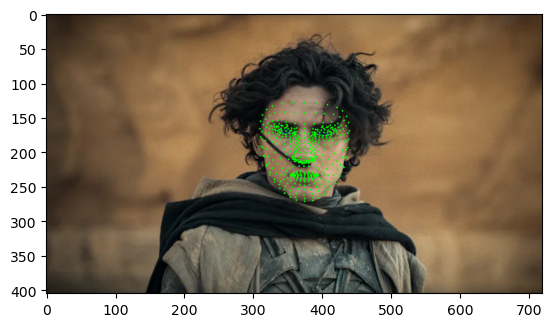

array([NormalizedLandmark(x=0.5214911699295044, y=0.5688496232032776, z=-0.013895725831389427, visibility=None, presence=None, name=None),
       NormalizedLandmark(x=0.5202001333236694, y=0.5282251238822937, z=-0.038157250732183456, visibility=None, presence=None, name=None),
       NormalizedLandmark(x=0.5204304456710815, y=0.5377479195594788, z=-0.016832780092954636, visibility=None, presence=None, name=None),
       NormalizedLandmark(x=0.5142530798912048, y=0.48130086064338684, z=-0.033144399523735046, visibility=None, presence=None, name=None),
       NormalizedLandmark(x=0.5202299356460571, y=0.5159346461296082, z=-0.04206579551100731, visibility=None, presence=None, name=None),
       NormalizedLandmark(x=0.5203958749771118, y=0.4969894289970398, z=-0.04101857915520668, visibility=None, presence=None, name=None),
       NormalizedLandmark(x=0.5212035179138184, y=0.4468696117401123, z=-0.026984132826328278, visibility=None, presence=None, name=None),
       NormalizedLandmark(x=

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

frame = cv2.imread("image/tests/timoty.png") # uint8, BGR
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
res = face_mesh_handler.process_frame_3d(frame)

landmarks = res.face_landmarks[0] # List[NormalizedLandmark(x, y, z, visibility, presence, name) ...], len = 478
blendshapes = res.face_blendshapes[0] # List[Category(index, score, display_name, category_name) ...], len = 52

h, w = frame.shape[:2]

for lamdmark in landmarks:
    x = int(lamdmark.x * w)
    y = int(lamdmark.y * h)
    cv2.circle(frame, (x,y), 1, (0,255,0), -1)
    
plt.imshow(frame)
plt.show()

np_landmarks = np.array(landmarks)
np_blendshapes = np.array(blendshapes)
np_landmarks
